In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.nn.functional import normalize

In [24]:
class SimCLRTransform:
    def __init__(self, size=32):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [25]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=SimCLRTransform())
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [26]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [27]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])
        self.projection_head = ProjectionHead(512, 256, projection_dim)

    def forward(self, x):
        h = self.base_model(x).squeeze()
        z = self.projection_head(h)
        return normalize(z, dim=1)

In [28]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        z = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = torch.mm(z, z.T)
        batch_size = z_i.size(0)

        labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(z.device)

        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(z.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = similarity_matrix[~labels.bool()].view(labels.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z.device)

        logits = logits / self.temperature
        loss = nn.CrossEntropyLoss()(logits, labels)
        return loss

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR(models.resnet18(pretrained=False), projection_dim=128).to(device)
criterion = NTXentLoss(temperature=0.5)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
from tqdm import tqdm

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    with tqdm(total=len(train_loader), desc="Training", unit="batch") as progress_bar:
        for (x_i, x_j), _ in train_loader:
            x_i, x_j = x_i.to(device), x_j.to(device)

            z_i = model(x_i)
            z_j = model(x_j)

            loss = criterion(z_i, z_j)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
            progress_bar.update(1)

    avg_loss = total_loss / len(train_loader)
    epoch_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Completed, Average Loss: {avg_loss:.4f}")

print("Training complete.")

Training: 100%|██████████| 196/196 [01:19<00:00,  2.47batch/s, loss=3.9545]


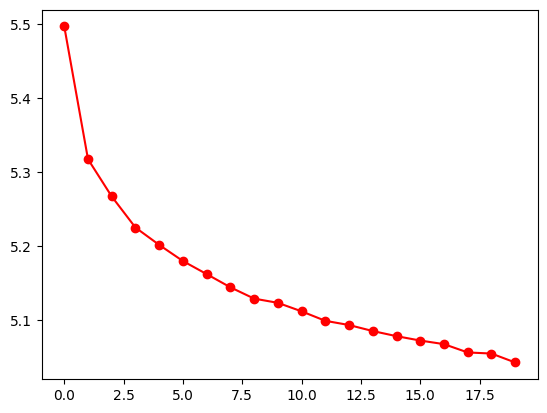

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs),  epoch_loss, color='red',  label='Training Loss', marker='o')

In [32]:
from torchinfo import summary

summary(model, input_size=(256, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
SimCLR                                        [256, 128]                --
├─Sequential: 1-1                             [256, 512, 1, 1]          --
│    └─Conv2d: 2-1                            [256, 64, 112, 112]       9,408
│    └─BatchNorm2d: 2-2                       [256, 64, 112, 112]       128
│    └─ReLU: 2-3                              [256, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [256, 64, 56, 56]         --
│    └─Sequential: 2-5                        [256, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [256, 64, 56, 56]         73,984
│    │    └─BasicBlock: 3-2                   [256, 64, 56, 56]         73,984
│    └─Sequential: 2-6                        [256, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [256, 128, 28, 28]        230,144
│    │    └─BasicBlock: 3-4                   [256, 128, 28, 28]        295,42